# RNA-Seq Count Normalization

**Created**: 18 December 2021

## Environment

In [59]:
if (!requireNamespace("BiocManager", quietly=TRUE)) {
    install.packages("BiocManager")
}

if (!require("limma", quietly=TRUE)) {
    BiocManager::install("limma")
}

if (!require("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!require("Rtsne", quietly=TRUE)) {
    install.packages("Rtsne")
}

if (!require("UpSetR", quietly=TRUE)) {
    install.packages("UpSetR")
}

In [60]:
library(tidyverse)
library(data.table)
library(limma)
library(edgeR)
library(Rtsne)
library(parallel)
library(UpSetR)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

## Load Data

In [5]:
read.counts <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/feature_counts_gene_counts.tsv")

In [6]:
head(read.counts)

Gene,SRR11007061,SRR11007062,SRR11007063,SRR11007064,SRR11007065,SRR11007066,SRR11007067,SRR11007068,SRR11007069,⋯,SRR7647807,SRR7647808,SRR7647809,SRR7647810,SRR7647811,SRR7647812,SRR7647813,SRR7647817,SRR7647818,SRR7647819
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,6,11,4,0,4,2,1,1,0,⋯,0,2,1,1,2,0,0,3,3,1
ENSG00000278267,0,2,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,1,0,0
ENSG00000284332,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_calderon_et_al_rna_seq.txt")

In [8]:
head(sample.info)

,Run,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Cell_type,Center.Name,Consent,⋯,LibrarySelection,LibrarySource,lineage,Organism,Platform,ReleaseDate,Sample.Name,source_name,SRA.Study,treatment
,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR11007061,RNA-Seq,192,8160479782,PRJNA484735,SAMN09768434,2579781267,CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319750,primary blood,SRP156452,no_treament
2,SRR11007062,RNA-Seq,195,15315982752,PRJNA484735,SAMN09768433,4836924733,CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319751,primary blood,SRP156452,treatment1
3,SRR11007063,RNA-Seq,195,13128598440,PRJNA484735,SAMN09768432,4155236675,Central_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319752,primary blood,SRP156452,no_treament
4,SRR11007064,RNA-Seq,193,4866405615,PRJNA484735,SAMN09768431,1546902050,Central_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319753,primary blood,SRP156452,treatment1
5,SRR11007065,RNA-Seq,195,9601276948,PRJNA484735,SAMN09768430,3023735003,Effector_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319754,primary blood,SRP156452,no_treament
6,SRR11007066,RNA-Seq,196,9273440229,PRJNA484735,SAMN09768429,2953466798,Effector_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319755,primary blood,SRP156452,treatment1


In [9]:
qc <- read.table("~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/rnaseqc.tsv", sep="\t", quote=c(), header=T, row.names=1)

qc <- as.data.frame(t(qc)) %>%
    dplyr::mutate(Run=rownames(.)) %>%
    dplyr::select(Run, everything())

colnames(qc) <- make.names(colnames(qc))

In [10]:
head(qc)

,Run,Mapping.Rate,Unique.Rate.of.Mapped,Duplicate.Rate.of.Mapped,Duplicate.Rate.of.Mapped..excluding.Globins,Base.Mismatch,End.1.Mapping.Rate,End.2.Mapping.Rate,End.1.Mismatch.Rate,End.2.Mismatch.Rate,⋯,Median.3..bias,X3..bias.Std,X3..bias.MAD_Std,X3..Bias..25th.Percentile,X3..Bias..75th.Percentile,Median.of.Avg.Transcript.Coverage,Median.of.Transcript.Coverage.Std,Median.of.Transcript.Coverage.CV,Median.Exon.CV,Exon.CV.MAD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SRR11007187,SRR11007187,1,0.554318,0.445682,0.445682,0,0,0,NaN,NaN,⋯,0.495462,0.341944,0.477280,0.2042250,0.866168,0.00000,0.000000,2.86513,0.686080,0.864111
SRR11007186,SRR11007186,1,0.524700,0.475300,0.475304,0,0,0,NaN,NaN,⋯,0.445049,0.330434,0.409247,0.1740140,0.729665,0.00000,0.000000,2.47362,0.540019,0.667721
SRR7647733,SRR7647733,1,0.476561,0.523439,0.523439,0,0,0,NaN,NaN,⋯,0.512658,0.320678,0.374392,0.3231130,0.846257,0.00000,0.000000,3.60718,0.858249,1.133200
SRR11007183,SRR11007183,1,0.526215,0.473785,0.473785,0,0,0,NaN,NaN,⋯,0.469697,0.316284,0.402435,0.1845680,0.727273,0.00000,0.000000,1.71143,0.292071,0.337954
SRR11007177,SRR11007177,1,0.503758,0.496242,0.496242,0,0,0,NaN,NaN,⋯,0.486111,0.331275,0.429063,0.2032000,0.783565,0.00000,0.000000,1.97889,0.448133,0.558728
SRR11007062,SRR11007062,1,0.549108,0.450892,0.450892,0,0,0,NaN,NaN,⋯,0.335178,0.325593,0.404272,0.0859729,0.666667,0.18148,0.596913,1.39695,0.279178,0.287746


## Limma-Voom Modeling

### Count Matrix

Set up the count matrix in the format required for Limma.

In [11]:
count.mtx <- as.matrix(read.counts[,-1])
rownames(count.mtx) <- read.counts$Gene

In [12]:
head(count.mtx)

,SRR11007061,SRR11007062,SRR11007063,SRR11007064,SRR11007065,SRR11007066,SRR11007067,SRR11007068,SRR11007069,SRR11007070,⋯,SRR7647807,SRR7647808,SRR7647809,SRR7647810,SRR7647811,SRR7647812,SRR7647813,SRR7647817,SRR7647818,SRR7647819
ENSG00000223972,0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,6,11,4,0,4,2,1,1,0,2,⋯,0,2,1,1,2,0,0,3,3,1
ENSG00000278267,0,2,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485,0,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0
ENSG00000284332,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [13]:
filtered.samples <- qc$Run[qc$Mapped.Reads > 1e7]
count.mtx <- count.mtx[, filtered.samples]

In [14]:
dim(count.mtx)

[1] 60676   165

### Create Sample Groups

The samples are grouped using cell type and treatment condition. The cell type and treatment group for each sample is stored in `groups`.

In [25]:
cell.type <- sample.info[match(colnames(count.mtx), sample.info$Run), "Cell_type"]
stimulated <- ifelse(sample.info[match(colnames(count.mtx), sample.info$Run), "treatment"] == "no_treament", "Baseline", "Stimulated")
groups <- interaction(cell.type, stimulated, sep="_")
groups <- droplevels(groups)

I will also be normalizing the data by removing batch effects. The donor is used as a categorical batch.

In [32]:
donors <- factor(sample.info[match(colnames(count.mtx), sample.info$Run), "Donor"])
donors <- droplevels(donors)

The design matrix indicates which samples belong to which groups.

In [34]:
design <- model.matrix(~0 + groups + donors)

### Create DGEList

`edgeR` can be used to handle count matrices. We will use `voom` in the next step to process this `edgeR` object.

In [35]:
dge <- DGEList(count.mtx)

Filter genes using in-built `edgeR` function.

In [36]:
keep <- filterByExpr(dge, group=groups)
dge <- dge[keep, , keep.lib.sizes=FALSE]

In [37]:
dim(dge)

[1] 45459   165

Calculate normalization factors for the trimmed mean of M-values method.

In [38]:
dge <- calcNormFactors(dge, method="TMM")

### Voom

`voom` models a count matrix by empirically identifying the mean-variance relationship within the data. The count matrix can then be normalized and batch effects can be removed. The normalized data can be used in downstream analysis with `limma`.

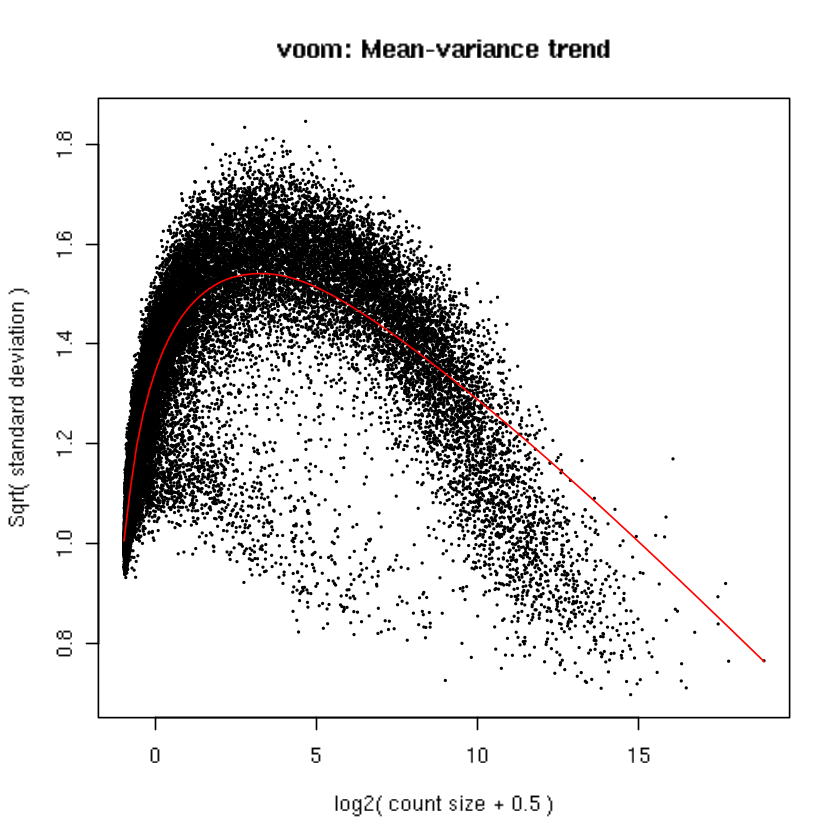

In [39]:
y <- voom(dge, design, plot=TRUE)

### Visualize Normalized Counts

In [41]:
pca <- prcomp(t(as.matrix(y)))

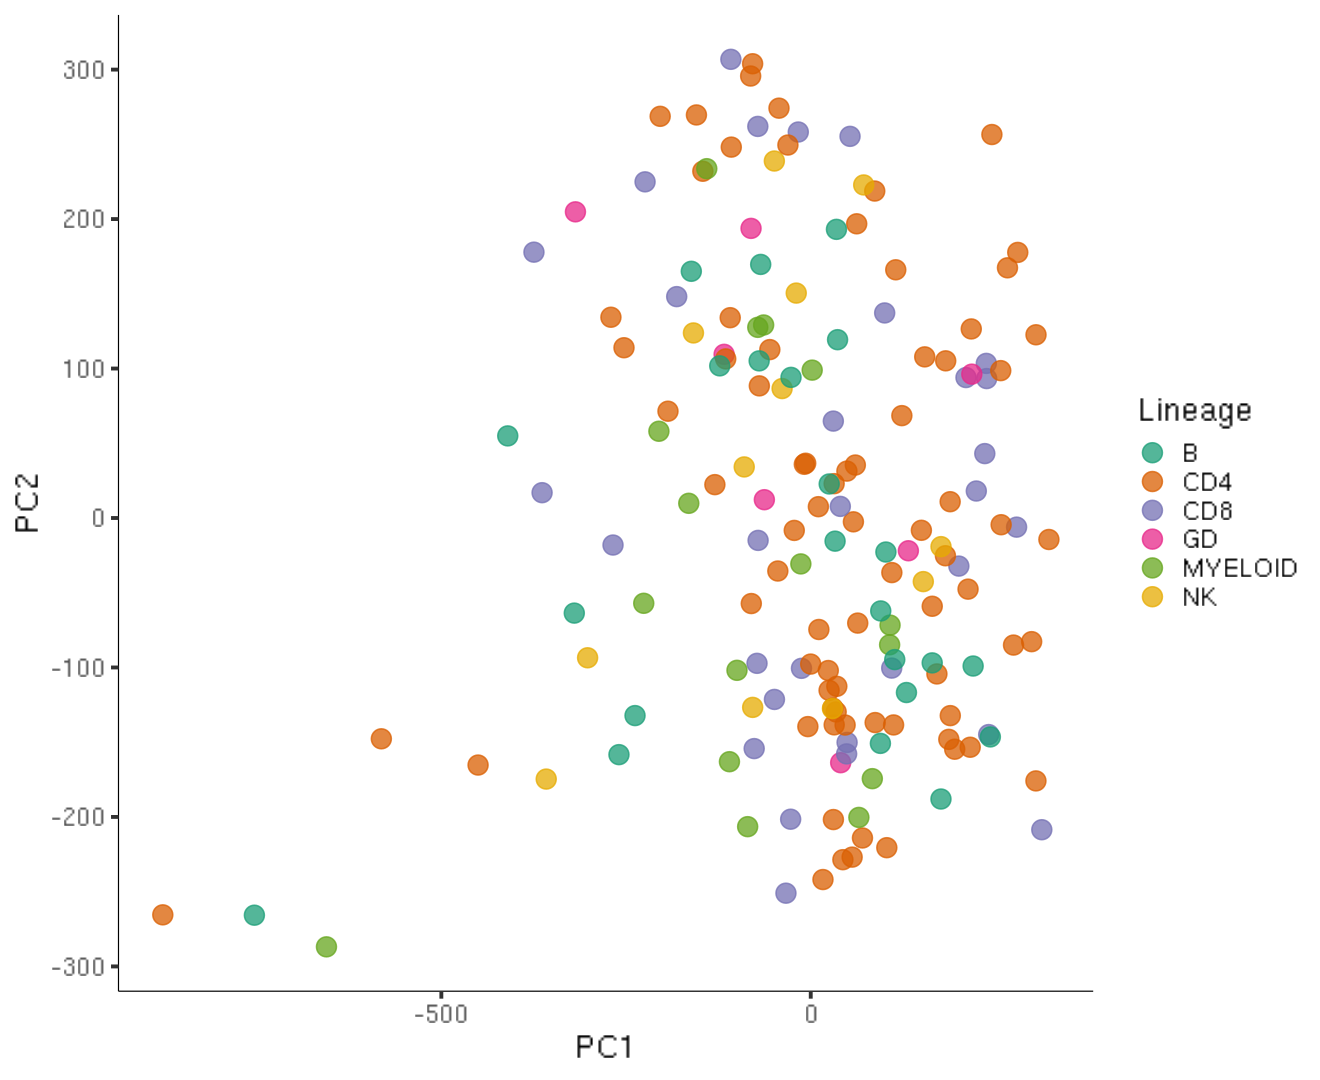

In [44]:
options(repr.plot.width=11, repr.plot.height=9)

merge(pca$x, sample.info, by.x=0, by.y="Run") %>%
    as.data.frame() %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2, color=lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    labs(color="Lineage") +
    ggplot_theme +
    theme(legend.position="right")

ggsave("03_Functional_Interpretation/results/normalized_read_count_pca.svg", width=8, height=9)

In [47]:
set.seed(9873945)
tsne.res <- Rtsne(t(as.matrix(y)[,stimulated == "Baseline"]), num_threads=4, perplexity=5)

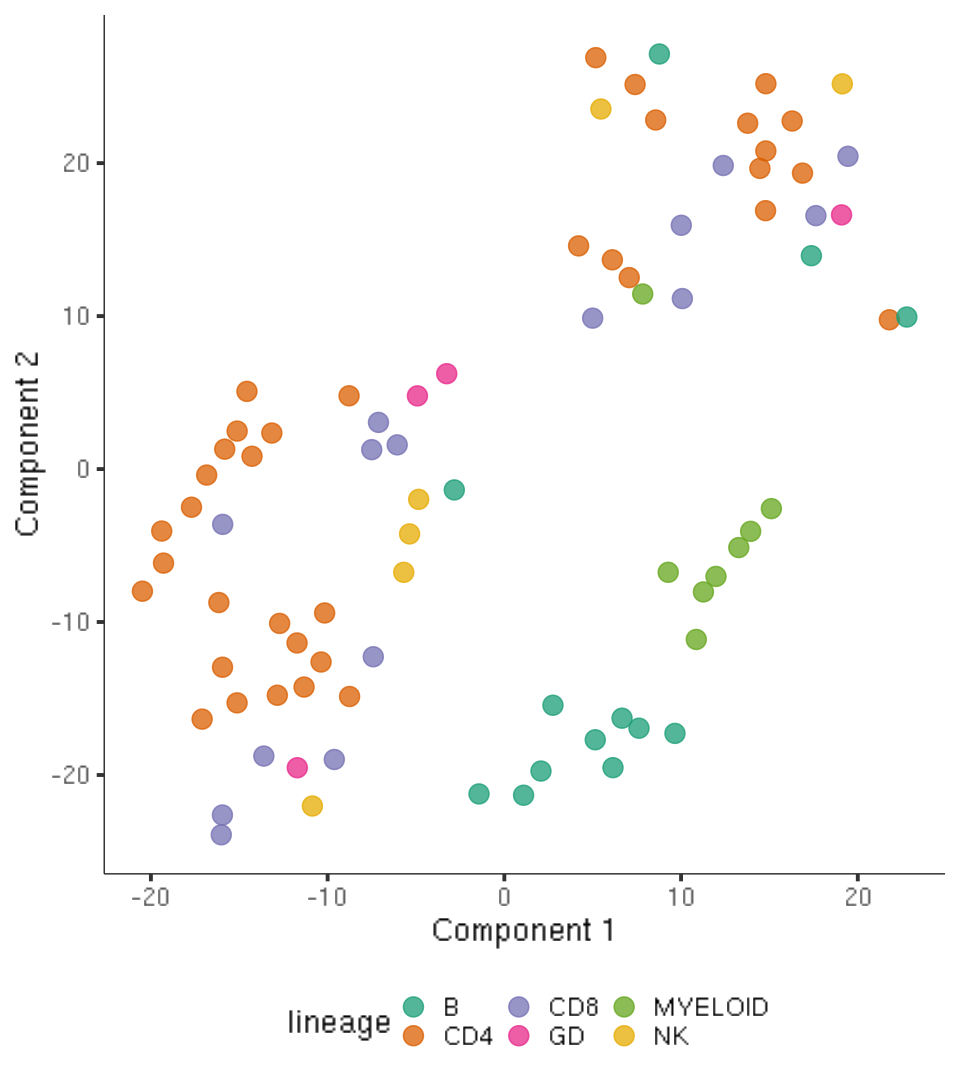

In [48]:
options(repr.plot.width=8, repr.plot.height=9)

tsne.res$Y %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Run=colnames(as.matrix(y)[,stimulated == "Baseline"])) %>%
    merge(., sample.info, by="Run") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/normalized_read_count_tsne.svg", width=8, height=9)

### Limma

Use `limma` to fit a linear model consisting of the biological `groups`.

In [49]:
fit <- lmFit(y, design)

### Limma DE Genes

Identify all cell types where both the baseline and stimulated conditions are present.

In [50]:
cell.type.conditions <- cbind(cell.type, stimulated) %>%
    as.data.frame() %>%
    dplyr::select(Cell.Type=1, Stimulated=2) %>%
    dplyr::group_by(Cell.Type, Stimulated) %>%
    dplyr::summarize(N=n(), .groups="drop") %>%
    tidyr::spread(Stimulated, N) %>%
    na.omit()

Create contrasts for each cell type that has both baseline and stimulated conditions.

In [51]:
contrast <- matrix(0, nrow=ncol(coef(fit)), ncol=nrow(cell.type.conditions))
rownames(contrast) <- colnames(coef(fit))
colnames(contrast) <- paste0(cell.type.conditions$Cell.Type, "_Stimulated-", cell.type.conditions$Cell.Type, "_Baseline")

for (i in 1:nrow(cell.type.conditions)) {
    cell.type.condition = cell.type.conditions$Cell.Type[i]
    contrast[paste0("groups", cell.type.condition, "_Stimulated"), i] = 1
    contrast[paste0("groups", cell.type.condition, "_Baseline"), i] = -1
}

In [52]:
de.genes <- rbindlist(lapply(1:ncol(contrast), function(i) {
    de.res = eBayes(contrasts.fit(fit, contrast[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)
    
    contrast.cell.type = strsplit(colnames(contrast)[i], "-")[[1]][1]
    contrast.cell.type = substr(contrast.cell.type, start=1, stop=nchar(contrast.cell.type) - 11)

    de.res.table %>%
        dplyr::mutate(Contrast=colnames(contrast)[i]) %>%
        dplyr::mutate(Cell.Type=contrast.cell.type) %>%
        dplyr::mutate(Gene.ID=rownames(.)) %>%
        dplyr::select(Contrast, Cell.Type, Gene.ID, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

## Differentially Expressed Genes

Calculate differentially expressed genes. For each contrast, a peak is considered differentially accessible if the adjusted P-value is < 0.01 and the absolute log fold change is greater than 1.

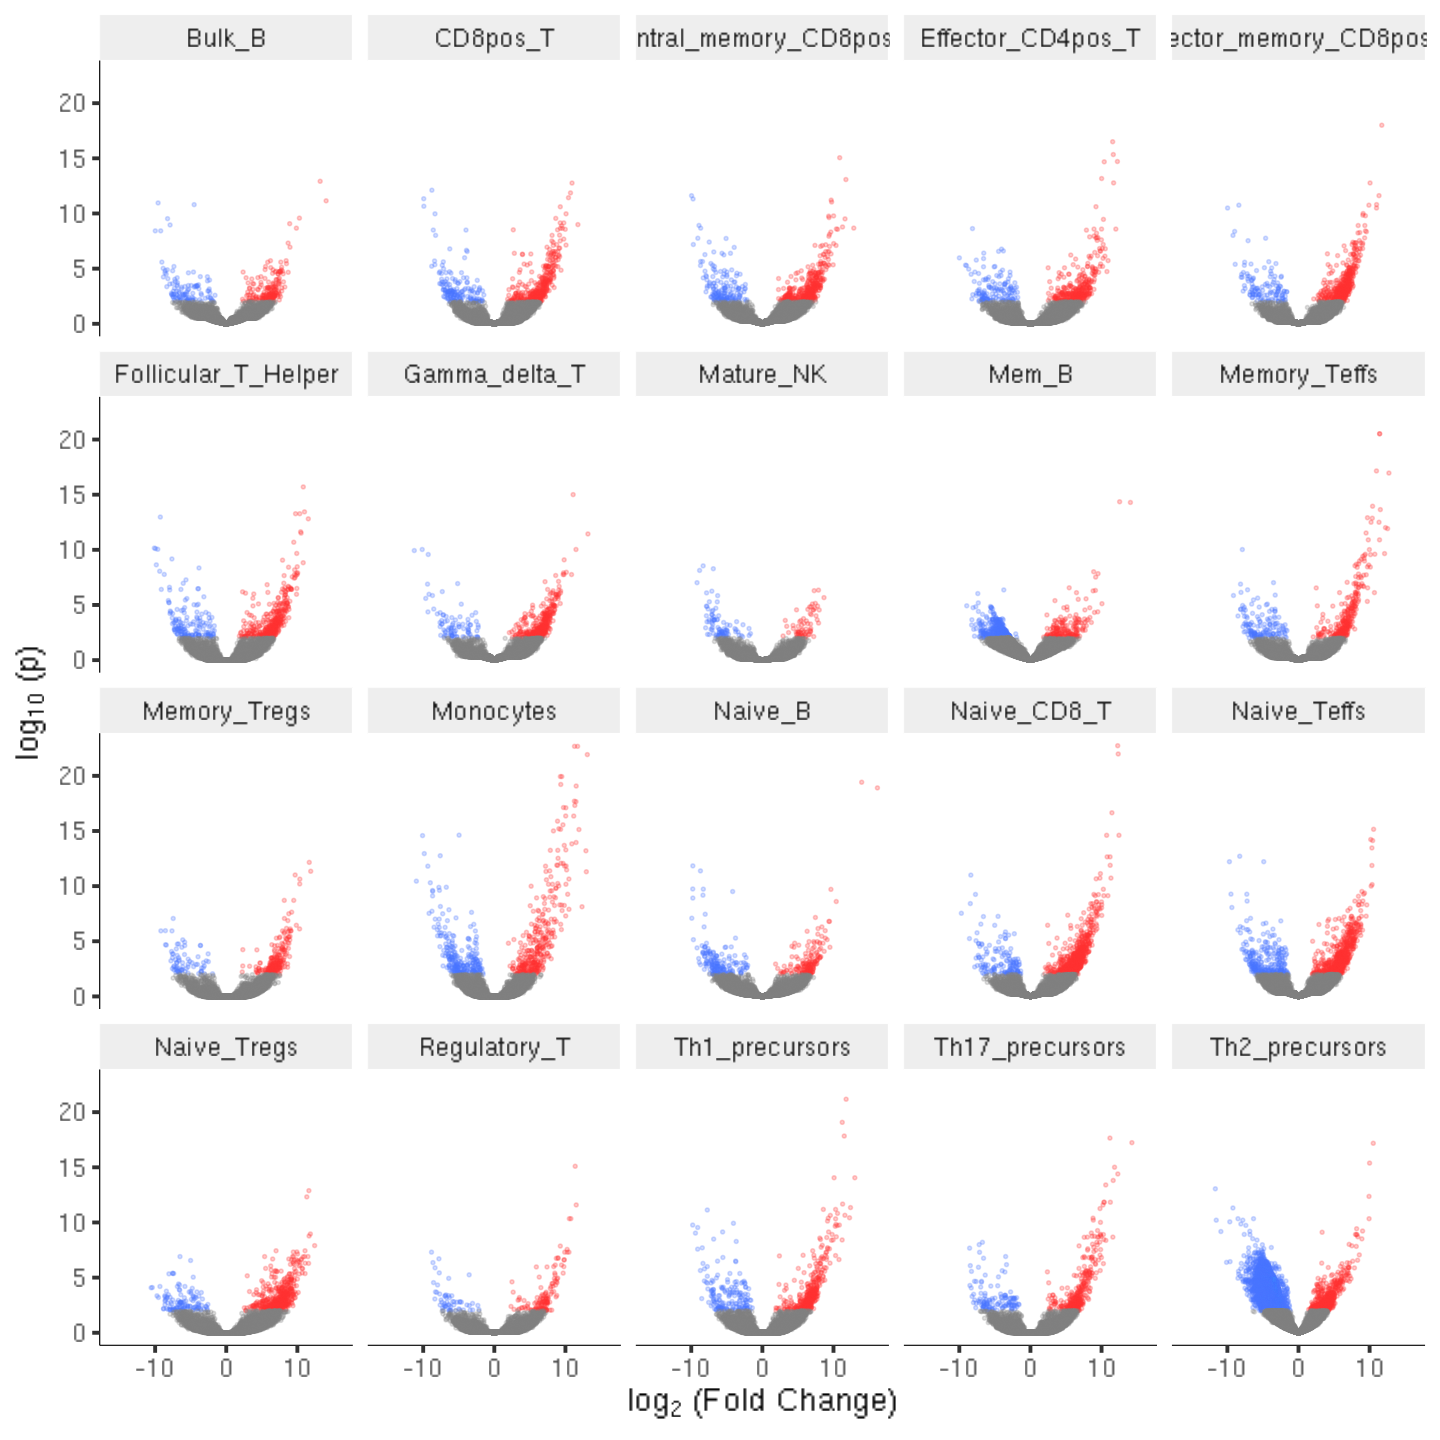

In [53]:
options(repr.plot.width=12, repr.plot.height=12)

abs.max.log.fc <- max(abs(de.genes$logFC))

de.genes %>%
    dplyr::mutate(log.adj.P.Val=-log10(adj.P.Val)) %>%
    dplyr::mutate(Accessible=ifelse(adj.P.Val < 0.01 & logFC > 1, "More", ifelse(adj.P.Val < 0.01 & logFC < -1, "Less", "Same"))) %>%
    ggplot() +
    geom_point(aes(x=logFC, y=log.adj.P.Val, color=Accessible), size=I(0.5), alpha=0.25) +
    scale_color_manual(values=c("More"="firebrick1", "Less"="royalblue1")) +
    guides(color="none") +
    facet_wrap(vars(Cell.Type)) +
    xlim(-abs.max.log.fc, abs.max.log.fc) +
    xlab(bquote("log"[2]~"(Fold Change)")) + ylab(bquote("log"[10]~"(p)")) +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/de_genes_volcano_plots.png", width=12, height=12)

In [54]:
de.genes.set <- de.genes %>%
    dplyr::filter(abs(logFC) > 1) %>%
    dplyr::filter(adj.P.Val < 0.01)

write.csv(de.genes.set, "~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/de_genes_set.csv")

There are 31,073 unique DE genes across all contrasts.

In [64]:
length(unique(de.genes.set$Gene.ID))

[1] 31073

In [65]:
length(unique(de.genes.set$Gene.ID[de.genes.set$Cell.Type != "Th2_precursors"]))

[1] 4657